In [1]:
from glob import iglob
from functools import reduce

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, col, explode
import matplotlib.pyplot as plt
from numpy import histogramdd
from sp8tools import SpkHits

Connect to PySpark master

In [2]:
builder = (SparkSession
           .builder
           .appName("PySpark Example")
#            .master("spark://carbon.uedalab.local:7077")
           .config("spark.jars.packages", "org.diana-hep:spark-root_2.11:0.1.15")
           .config("spark.cores.max", 1)
#            .config("spark.executor.cores", 3)
           .config("spark.executor.memory", "16g")
           )
spark = builder.getOrCreate()

Read root files

In [3]:
globbed = iglob("/helium/analysis/saito/SortEvent_aq002_t100_b.root")
loaded = (spark.read.format("org.dianahep.sparkroot").load(fn) for fn in globbed)
df = reduce(DataFrame.unionAll, loaded)
df.printSchema()

root
 |-- SortedEvent: struct (nullable = true)
 |    |-- fEventID: long (nullable = true)
 |    |-- fDetektors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- fDetektors_fHits: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- fPDNbr: integer (nullable = true)
 |    |    |    |    |    |-- fHitNbr: integer (nullable = true)
 |    |    |    |    |    |-- fU1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fU2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fMcpNbr: integer (nullable = true)
 |    |    |    |    |    |-- fX_mm: double (nullable = true)
 |    |    |    |    |    |-- fY_mm: double (

Restruct

In [4]:
@udf(SpkHits)
def combine_hits(xarr, yarr, tarr, flagarr):
    return [{'x': x,
             'y': y,
             't': t,
             'flag': f
            } for x, y, t, f in zip(xarr, yarr, tarr, flagarr)]


chits = col('SortedEvent.fDetektors')[0]['fDetektors_fHits']
restructed = (df
              .withColumn('hits', combine_hits(chits.getField('fX_mm'),
                                               chits.getField('fY_mm'),
                                               chits.getField('fTime'),
                                               chits.getField('fRekmeth')))
              .select(col('SortedEvent.fEventID').alias("tag"), 'hits'))
restructed.printSchema()

root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)
 |    |    |-- as: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)



Load data to Memory

In [5]:
flatten = (
    restructed
    .select('tag', explode('hits').alias('hit'))
    .select('tag', 'hit.*')
)
flatten.show()

+---------+------------------+-------------------+-------------------+----+----+
|      tag|                 t|                  x|                  y|flag|  as|
+---------+------------------+-------------------+-------------------+----+----+
|145971392|2155.8714754647817| 1.1890323927161996|-12.081262568683488|   0|null|
|145971392|2924.6959933031167| 0.8803779281276898| -1.515407717579692|   0|null|
|145971392|2995.3602368650045| 1.3607242163968394|-3.0345299909682635|   0|null|
|145971394| 873.4811857939335| -10.23546779811233| 17.575936842421484|   0|null|
|145971394|1037.1305616154725|-19.330096389750203| 2.8656693843826684|   0|null|
|145971394|2106.4386612172943| 1.0400755269290387|  3.301881280137216|   7|null|
|145971394| 2111.896585118278| 13.188640176667981| 0.9254700975975497|   9|null|
|145971394|2943.8388629138444|0.38281987147079627|  -7.13811854753785|   0|null|
|145971394| 3012.376831189321|  1.159512545653608|-2.3373063699128918|  16|null|
|145971394|3025.774427437899

In [7]:
pdf = flatten.limit(1000000).toPandas()
pdf.head()

,tag,t,x,y,flag,as
0,145971392,2155.871475,1.189032,-12.081263,0,None
1,145971392,2924.695993,0.880378,-1.515408,0,None
2,145971392,2995.360237,1.360724,-3.034530,0,None
3,145971394,873.481186,-10.235468,17.575937,0,None
4,145971394,1037.130562,-19.330096,2.865669,0,None


TOF and FISH

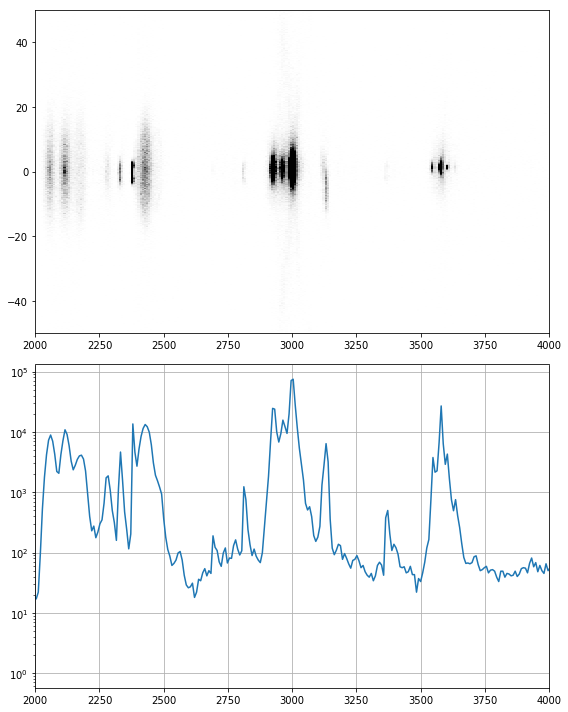

In [8]:
hist, (xedges, yedges) = histogramdd(
    (pdf['t'], pdf['x']),
    bins=(1000, 1000),
    range=((0, 8000), (-50, 50))
)

plt.figure(figsize=(8, 10))
plt.subplot(211)
plt.pcolormesh(xedges, yedges, hist.T, cmap="Greys")
plt.xlim(2000, 4000)
plt.clim(0, 100)

plt.subplot(212)
plt.plot((xedges[1:]+xedges[:-1])/2, hist.sum(1))
plt.xlim(2000, 4000)
plt.grid(True)
plt.yscale("log")

plt.tight_layout()
plt.show()

In [9]:
spark.stop()